In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Detecçao de emoção

In [2]:
# aumento de dados (data augmentation) de imagens durante o treinamento de modelos.
IMG_SIZE = 48
BATCH_SIZE = 64
data_gen_train = ImageDataGenerator()

In [3]:
data_gen_train = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    validation_split=0.2
)

data_gen_test = ImageDataGenerator(rescale = 1./255)

In [4]:
train_generator = data_gen_train.flow_from_directory(
    'train/',  # Diretório com dados de treino
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

Found 12173 images belonging to 3 classes.


In [5]:
validation_generator = data_gen_train.flow_from_directory(
    'train/',  # Mesmo diretório de treino
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True,
    subset='validation', 
    seed=42
)

Found 3043 images belonging to 3 classes.


In [6]:
test_generator = data_gen_test.flow_from_directory(
    'test/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

Found 3852 images belonging to 3 classes.


In [7]:
# Acessar as classes e conte quantas imagens há em cada classe
class_counts = np.bincount(train_generator.classes)

class_indices = train_generator.class_indices

for class_name, class_index in class_indices.items():
    print(f"Classe: {class_name}, Imagens: {class_counts[class_index]}")

Classe: happy, Imagens: 5772
Classe: sad, Imagens: 3864
Classe: surprise, Imagens: 2537


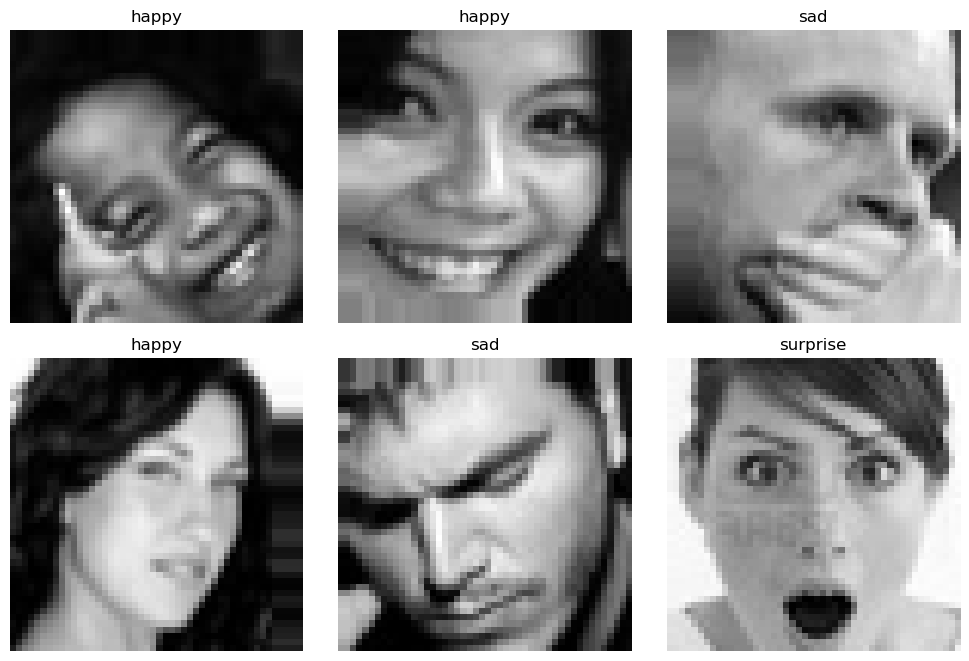

In [8]:
# Obter uma amostra de imagens e labels do generator
images, labels = next(train_generator) 

num_images = 6

class_labels = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1) 
    img = images[i].squeeze() 
    label = np.argmax(labels[i]) 
    
    plt.imshow(img, cmap='gray')
    plt.title(class_labels[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential()

# Primeira camada convolucional com 32 filtros
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())  # Normalização
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))  # MaxPooling para redução espacial
model.add(Dropout(0.2))  # Dropout para reduzir overfitting

# Segunda camada convolucional com 64 filtros
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.3))

# Terceira camada convolucional com 128 filtros
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))  # Pooling após terceira camada
model.add(Dropout(0.4))

# Achatar a saída das camadas anteriores para alimentar a camada densa
model.add(Flatten())

# Camada densa com 512 unidades
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Camada de saída com 3 unidades para classificação multiclasse
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        2

In [11]:
# Callbacks
from keras import callbacks
callbacks =[
    callbacks.EarlyStopping(patience = 10), # Se a validation persistir por 10 epocas, para o treino
    callbacks.ModelCheckpoint(save_bet_only = True, filepath='model.keras')
]

In [12]:
from sklearn.utils import class_weight

#penalizar erros nas classes com menos exemplos.
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(train_generator.classes), 
                                                  y=train_generator.classes)

In [13]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/25


191/191 [==============================] - 46s 230ms/step - loss: 1.3693 - accuracy: 0.4448 - val_loss: 4.8645 - val_accuracy: 0.3174
Epoch 2/25
191/191 [==============================] - 32s 168ms/step - loss: 0.9502 - accuracy: 0.5328 - val_loss: 1.6583 - val_accuracy: 0.4289
Epoch 3/25
191/191 [==============================] - 26s 137ms/step - loss: 0.8789 - accuracy: 0.5855 - val_loss: 0.8720 - val_accuracy: 0.5991
Epoch 4/25
191/191 [==============================] - 26s 137ms/step - loss: 0.8226 - accuracy: 0.6183 - val_loss: 0.8242 - val_accuracy: 0.6241
Epoch 5/25
191/191 [==============================] - 29s 153ms/step - loss: 0.7873 - accuracy: 0.6427 - val_loss: 0.7302 - val_accuracy: 0.6668
Epoch 6/25
191/191 [==============================] - 26s 135ms/step - loss: 0.7385 - accuracy: 0.6672 - val_loss: 0.6921 - val_accuracy: 0.6977
Epoch 7/25
191/191 [==============================] - 25s 133ms/step - loss: 0.7073 - accuracy: 0.6809 - val_loss: 0.8026 - val_

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

61/61 [==============================] - 5s 82ms/step - loss: 0.4842 - accuracy: 0.8159
Test accuracy: 0.8159397840499878


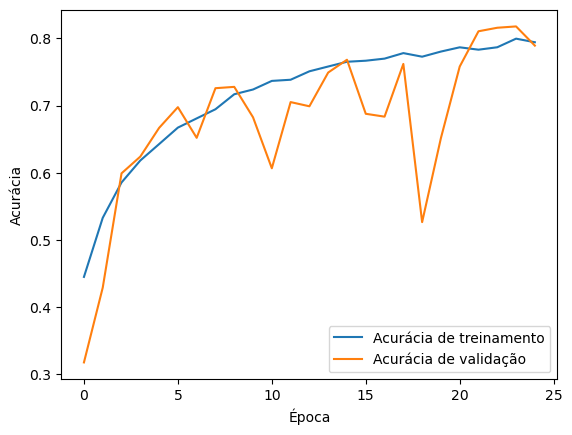

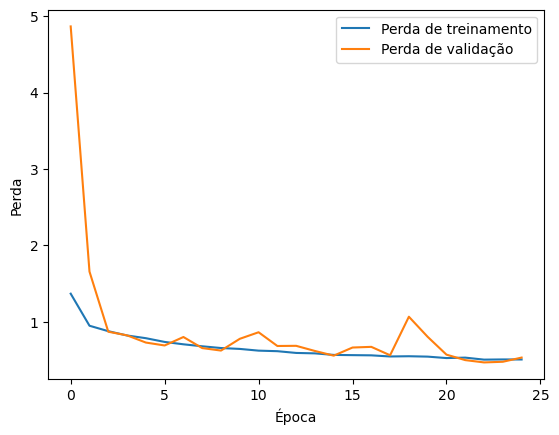

In [15]:
# Plotar acurácia
plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.show()

# Plotar perda
plt.plot(history.history['loss'], label='Perda de treinamento')
plt.plot(history.history['val_loss'], label='Perda de validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper right')
plt.show()

In [16]:
model.save("model_final.keras")

# Teste

In [17]:
from tensorflow.keras.models import load_model

In [18]:
model = load_model('model_final.keras')

In [ ]:
predictions = model.predict(test_generator)

31/61 [==============>...............] - ETA: 1s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Converter previsões em rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

class_labels = {v: k for k, v in test_generator.class_indices.items()}

num_images = 20
images, _ = next(test_generator) 

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    img = images[i].squeeze() 
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    plt.imshow(img, cmap='gray')
    plt.title(f"Real: {class_labels[true_label]}\nPred: {class_labels[predicted_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
